# Simple Neural Implementation of Iterative MAP Calculation (WITH LEARNING)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Util functions
def g(v):
    return np.square(v)

def dg(v):
    return 2*v

In [3]:
# Initialises the network, before learning
def init(u=2, v_p=3, Sigma_u=1, Sigma_p=1, phi=3, eps_u=0, eps_p=0):
    state = {
        'u': u,
        # Update these
        'phi': phi,
        'eps_u': eps_u,
        'eps_p': eps_p,
        't': 0,
        # Learn these. Stored as lists to keep track of history
        'v_p': [v_p],
        'Sigma_u': [Sigma_u],
        'Sigma_p': [Sigma_p],
    }
    return state

# Generates a new sample and resets the state
def new_sample(state, true_v_mean, true_v_sigma, true_u_sigma):
    # Generate new sample from true distribution
    true_v = np.random.normal(true_v_mean, true_v_sigma)
    u = np.random.normal(g(true_v), true_u_sigma)

    state['u'] = u
    state['phi'] = state['v_p'][-1]
    state['eps_u'] = 0
    state['eps_p'] = 0
    state['t'] = 0

    return state

# Updates the state of the network by gradient ascent on F (no learning)
def update(state, dt=0.01):
    # Calculate gradients
    dF_deps_p = state['phi'] - state['v_p'][-1] - state['Sigma_p'][-1] * state['eps_p']
    dF_deps_u = state['u'] - g(state['phi']) - state['Sigma_u'][-1] * state['eps_u']
    dF_dphi = state['eps_u'] * dg(state['phi']) - state['eps_p']

    # Perform gradient ascent
    state['eps_p'] += dt * dF_deps_p
    state['eps_u'] += dt * dF_deps_u
    state['phi'] += dt * dF_dphi

    state['t'] += dt

    return state

# Learn parameters by gradient ascent on F. Call after network has converged
def learn(state, lr=0.01, min_sigma=1.0):
    # Calculate gradients
    dFdv_p = state['eps_p']
    dFdSigma_p = 0.5 * (state['eps_p'] * state['eps_p'] - 1/state['Sigma_p'][-1])
    dFdSigma_u = 0.5 * (state['eps_u'] * state['eps_u'] - 1/state['Sigma_u'][-1])

    # Perform gradient ascent
    state['v_p'].append(state['v_p'][-1] + lr * dFdv_p)
    state['Sigma_p'].append(state['Sigma_p'][-1] + lr * dFdSigma_p) 
    state['Sigma_u'].append(state['Sigma_u'][-1] + lr * dFdSigma_u)

    # Enforce minimum Sigma, per Friston 2005
    if min_sigma is not None:
        if state['Sigma_p'][-1] < min_sigma:
            state['Sigma_p'][-1] = min_sigma
        if state['Sigma_u'][-1] < min_sigma:
            state['Sigma_u'][-1] = min_sigma

    return state, (dFdv_p, dFdSigma_p, dFdSigma_u)


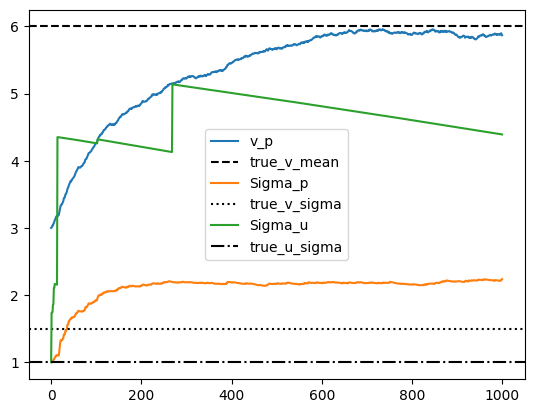

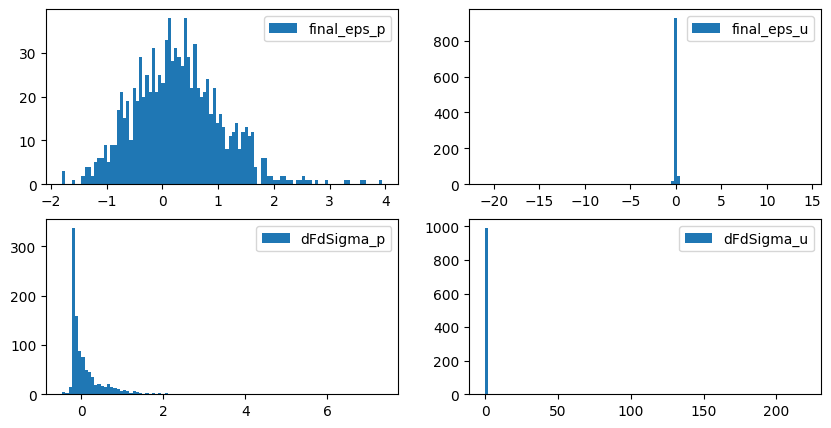

In [11]:
# True Statistics
true_v_mean = 6
true_v_sigma = 1.5
true_u_sigma = 1.0

# Initialises network and tracking lists
state = init()
final_eps_p = []
final_eps_u = []
grads_Sigma_p = []
grads_Sigma_u = []

for _ in range(1000):
    state = new_sample(state, true_v_mean, true_v_sigma, true_u_sigma)    

    while state['t'] < 5:
        state = update(state)
    state, grads = learn(state, min_sigma=0.5) # Reduced from 1.0 so we can see how it learns

    # Track statistics
    final_eps_p.append(state['eps_p'])
    final_eps_u.append(state['eps_u'])
    grads_Sigma_p.append(grads[1])
    grads_Sigma_u.append(grads[2])

plt.plot(state['v_p'], label='v_p')
plt.axhline(true_v_mean, color='black', linestyle='--', label='true_v_mean')
plt.plot(state['Sigma_p'], label='Sigma_p')
plt.axhline(true_v_sigma, color='black', linestyle=':', label='true_v_sigma')
plt.plot(state['Sigma_u'], label='Sigma_u')
plt.axhline(true_u_sigma, color='black', linestyle='-.', label='true_u_sigma')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].hist(final_eps_p, bins=100, label='final_eps_p')
axs[0,0].legend()
axs[0,1].hist(final_eps_u, bins=100, label='final_eps_u')
axs[0,1].legend()
axs[1,0].hist(grads_Sigma_p, bins=100, label='dFdSigma_p')
axs[1,0].legend()
axs[1,1].hist(grads_Sigma_u, bins=100, label='dFdSigma_u')
axs[1,1].legend()

plt.show()

In [12]:
print('grads_Sigma_p mean & var: ', np.mean(grads_Sigma_p), np.var(grads_Sigma_p))
print('grads_Sigma_u mean & var: ', np.mean(grads_Sigma_u), np.var(grads_Sigma_u))

grads_Sigma_p mean & var:  0.12371070211156694 0.41242494829418175
grads_Sigma_u mean & var:  0.3392184015228738 64.54952182113584
